## Time Series Forecasting

In [37]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 20.3 MB/s eta 0:00:0000:0100:01


In [88]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import yfinance as yf
import warnings
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error


[*********************100%***********************]  1 of 1 completed

S&P 500 Dataset:
Price             Close         High          Low         Open      Volume
Ticker            ^GSPC        ^GSPC        ^GSPC        ^GSPC       ^GSPC
Date                                                                      
2013-01-02  1462.420044  1462.430054  1426.189941  1426.189941  4202600000
2013-01-03  1459.369995  1465.469971  1455.530029  1462.420044  3829730000
2013-01-04  1466.469971  1467.939941  1458.989990  1459.369995  3424290000
2013-01-07  1461.890015  1466.469971  1456.619995  1466.469971  3304970000
2013-01-08  1457.150024  1461.890015  1451.640015  1461.890015  3601600000

Dataset information:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2518 entries, 2013-01-02 to 2022-12-30
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   (Close, ^GSPC)   2518 non-null   float64
 1   (High, ^GSPC)    2518 non-null   float64
 2   (Low, ^GSPC)     2518 non-null   float64
 3   (O

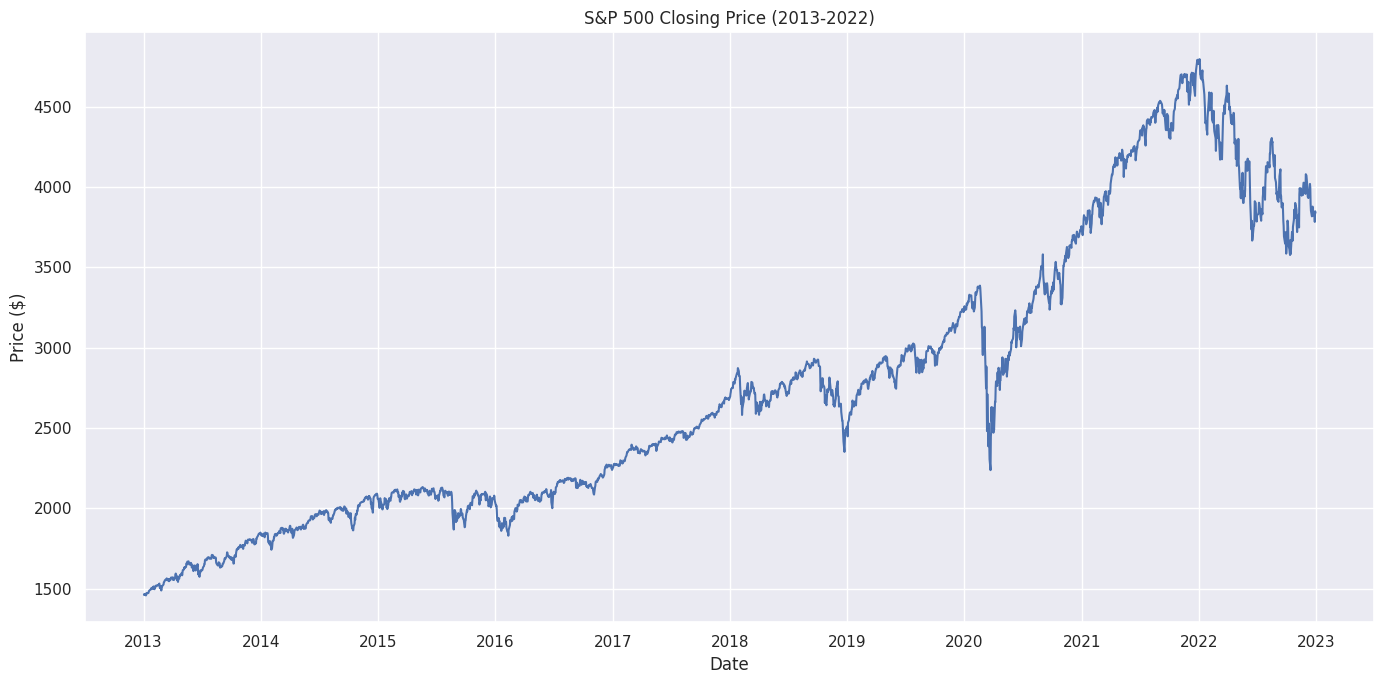


Selected time series shape: (2518, 1)


In [89]:

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')


# Set plotting style
sns.set_theme()


# Download S&P 500 data for the last 10 years
sp500 = yf.download('^GSPC', start='2013-01-01', end='2022-12-31')


# Display the first few rows of the dataset
print("S&P 500 Dataset:")
print(sp500.head())


# Display basic information about the dataset
print("\nDataset information:")
print(sp500.info())


# Calculate basic summary statistics
print("\nSummary Statistics:")
print(sp500['Close'].describe())


# Check for missing values
print("\nMissing values in each column:")
print(sp500.isnull().sum())


# Plot the closing price
plt.figure(figsize=(14, 7))
plt.plot(sp500.index, sp500['Close'])
plt.title('S&P 500 Closing Price (2013-2022)')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.grid(True)
plt.tight_layout()
plt.show()


# Select the closing price as our primary time series for analysis
ts_data = sp500['Close']
print("\nSelected time series shape:", ts_data.shape)

In [90]:
#ts_data.head(20)
print(ts_data['^GSPC'])

Date
2013-01-02    1462.420044
2013-01-03    1459.369995
2013-01-04    1466.469971
2013-01-07    1461.890015
2013-01-08    1457.150024
                 ...     
2022-12-23    3844.820068
2022-12-27    3829.250000
2022-12-28    3783.219971
2022-12-29    3849.280029
2022-12-30    3839.500000
Name: ^GSPC, Length: 2518, dtype: float64


In [91]:
ts_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2518 entries, 2013-01-02 to 2022-12-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ^GSPC   2518 non-null   float64
dtypes: float64(1)
memory usage: 39.3 KB


In [92]:
ts_data.head()

Ticker,^GSPC
Date,
2013-01-02,1462.420044
2013-01-03,1459.369995
2013-01-04,1466.469971
2013-01-07,1461.890015
2013-01-08,1457.150024


In [93]:
df = ts_data.reset_index()

df.head()

Ticker,Date,^GSPC
0,2013-01-02,1462.420044
1,2013-01-03,1459.369995
2,2013-01-04,1466.469971
3,2013-01-07,1461.890015
4,2013-01-08,1457.150024


In [94]:
df['^GSPC']

0       1462.420044
1       1459.369995
2       1466.469971
3       1461.890015
4       1457.150024
           ...     
2513    3844.820068
2514    3829.250000
2515    3783.219971
2516    3849.280029
2517    3839.500000
Name: ^GSPC, Length: 2518, dtype: float64

In [95]:
print(df['Date'])

0      2013-01-02
1      2013-01-03
2      2013-01-04
3      2013-01-07
4      2013-01-08
          ...    
2513   2022-12-23
2514   2022-12-27
2515   2022-12-28
2516   2022-12-29
2517   2022-12-30
Name: Date, Length: 2518, dtype: datetime64[ns]


In [96]:
df.rename(columns={'^GSPC': 'GSPC'}, inplace=True)

In [97]:
df.head()

Ticker,Date,GSPC
0,2013-01-02,1462.420044
1,2013-01-03,1459.369995
2,2013-01-04,1466.469971
3,2013-01-07,1461.890015
4,2013-01-08,1457.150024


In [98]:
df['Date'] = pd.to_datetime(df['Date'])

In [99]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2518 entries, 0 to 2517
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    2518 non-null   datetime64[ns]
 1   GSPC    2518 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 39.5 KB


In [100]:
df.set_index('Date', inplace=True)

In [101]:
#Pretty much got to this point by playing with the data.  Haven't changed anything, just now is in DF and removed the carrot from GSPC
df.head()

Ticker,GSPC
Date,
2013-01-02,1462.420044
2013-01-03,1459.369995
2013-01-04,1466.469971
2013-01-07,1461.890015
2013-01-08,1457.150024


In [102]:
df = df.sort_index()

In [103]:
df.head()

Ticker,GSPC
Date,
2013-01-02,1462.420044
2013-01-03,1459.369995
2013-01-04,1466.469971
2013-01-07,1461.890015
2013-01-08,1457.150024


In [104]:
# Check for Stationary - it is not
result = adfuller(df['GSPC'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')


ADF Statistic: -1.0312090768619362
p-value: 0.7417120357643819


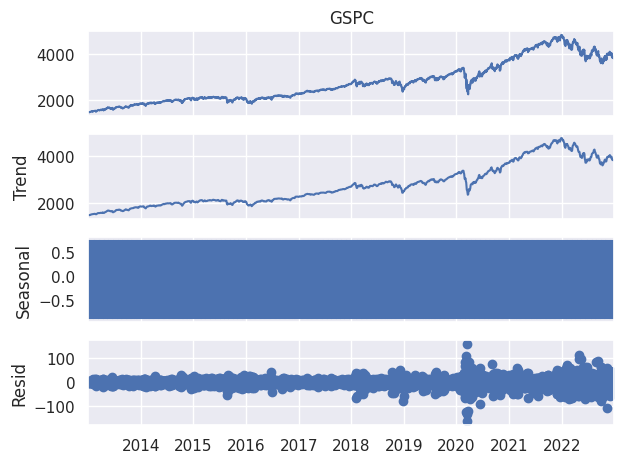

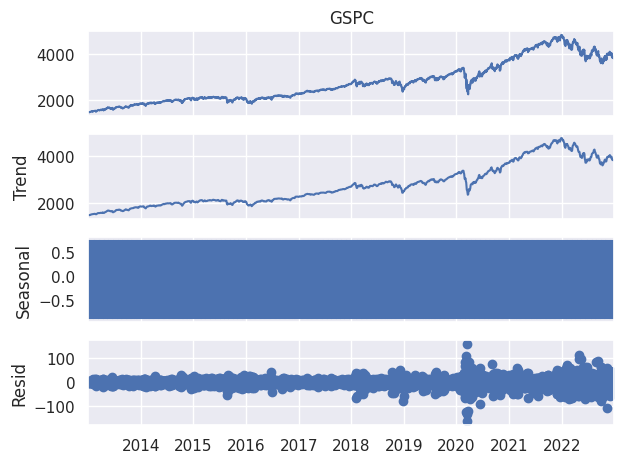

In [105]:
#Check for seasonality - none exists.  Tried 12 for months, 6 for bi monthly, 52 for weekly.  None exists.
result = seasonal_decompose(df['GSPC'], model='additive', period=4)  
result.plot()


In [106]:
# Get log of GSPC and Diff for stationary
df['log_gspc'] = np.log(df['GSPC'])
df['GSPC_diff'] = df['GSPC'].diff().dropna()


In [107]:
df.head()

Ticker,GSPC,log_gspc,GSPC_diff
Date,,,
2013-01-02,1462.420044,7.287848,NaN
2013-01-03,1459.369995,7.285760,-3.050049
2013-01-04,1466.469971,7.290613,7.099976
2013-01-07,1461.890015,7.287485,-4.579956
2013-01-08,1457.150024,7.284238,-4.739990


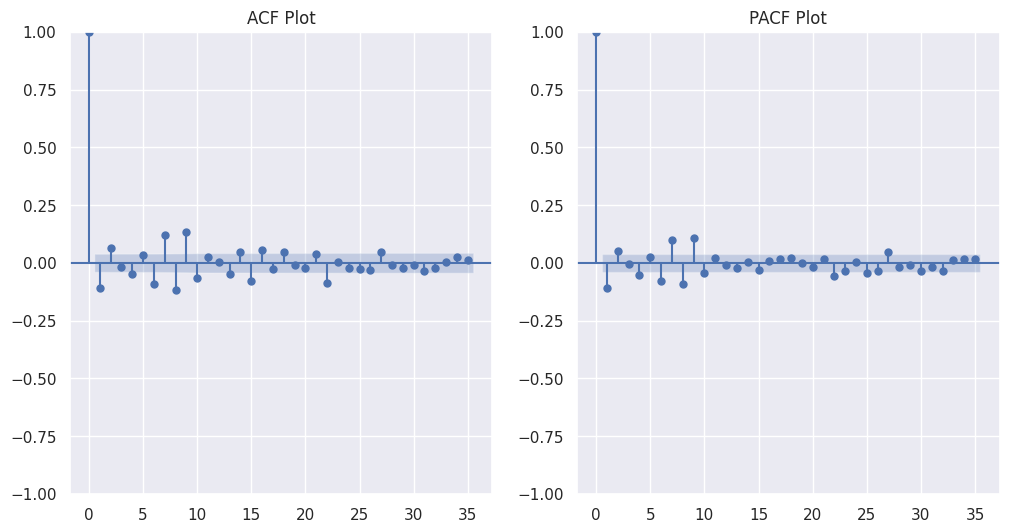

In [108]:
# ACF and PACF plots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot ACF
plot_acf(df['GSPC_diff'].dropna(), ax=axes[0])
axes[0].set_title("ACF Plot")

# Plot PACF
plot_pacf(df['GSPC_diff'].dropna(), ax=axes[1])
axes[1].set_title("PACF Plot")

plt.show()

In [109]:
# Found package pmdarima which automatically runs through ARIMA to find best fit.  Used this to get values.  Chose 5 as max because based on the graphs above it looks like it should be 4 max.
stepwise_model = auto_arima(df['GSPC'], start_p=1, start_q=1,
                            max_p=5, max_q=5, seasonal=False,
                            d=1, trace=True, error_action='ignore', suppress_warnings=True)
print(stepwise_model.summary())


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=24782.240, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=24813.280, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=24784.936, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=24787.938, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=24813.288, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=24782.422, Time=0.31 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=24781.855, Time=0.46 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=24780.739, Time=0.31 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=24780.647, Time=0.43 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=24780.797, Time=0.89 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=24779.674, Time=0.46 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=24735.301, Time=1.17 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=24696.877, Time=1.65 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=24782.179, Time=0.96 sec
 ARIMA(3,1,4)(0,0,0

In [110]:
#Create ARIMA model
gspc_model = ARIMA(df['GSPC'].dropna(), order=(2,1,2))
gspc_model_fit = gspc_model.fit()

# Print model AIC, BIC
aic = round(gspc_model_fit.aic, 1)
bic = round(gspc_model_fit.bic, 1)

aic, bic

(24692.3, 24721.4)

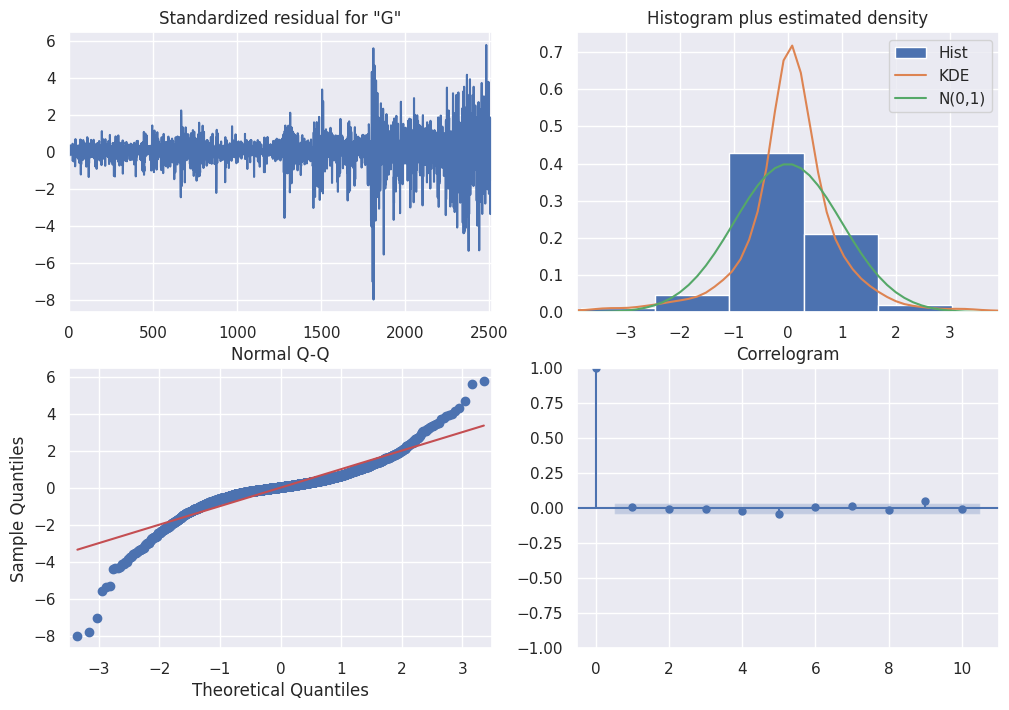

In [111]:
# Model Diagnostics
gspc_model_fit.plot_diagnostics(figsize=(12,8))
plt.show()

In [112]:
# Forecast next year
forecast = gspc_model_fit.forecast(steps=252) #252 trading days in a year


# Create future index
future_dates = pd.date_range(start=df.index[-1] + pd.DateOffset(days=1), periods=252)

forecast

2518    3851.317030
2519    3842.349393
2520    3847.672292
2521    3846.233448
2522    3844.068975
           ...     
2765    3845.986667
2766    3845.986665
2767    3845.986667
2768    3845.986665
2769    3845.986667
Name: predicted_mean, Length: 252, dtype: float64

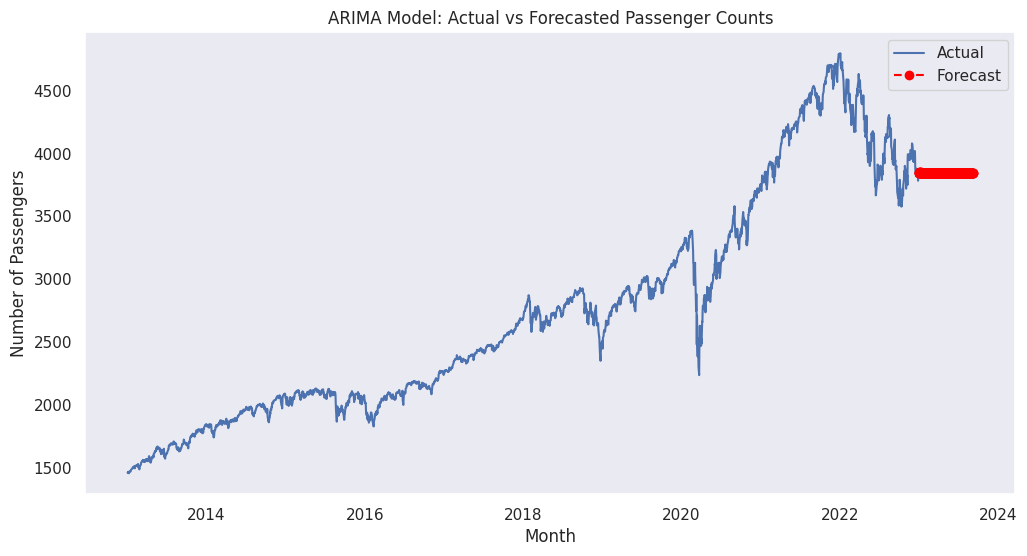

In [113]:
plt.figure(figsize=(12, 6))

# Plot actual data
plt.plot(df.index, df['GSPC'], label="Actual", linestyle='-')

# Plot forecasted values
plt.plot(future_dates, forecast, label="Forecast", marker='o', linestyle='--', color='red')
plt.title("ARIMA Model: Actual vs Forecasted Passenger Counts")
plt.xlabel("Month")
plt.ylabel("Number of Passengers")
plt.legend()
plt.grid()
plt.show()

In [114]:

# Get predictions
predictions = gspc_model_fit.predict(start=1, end=len(df))  # Get predictions for the original time series range

# True values
true_values = df['GSPC']

# predictions = predictions[true_values.index]  # Align predictions with true_values index
predictions = predictions.to_numpy()




# Calculate error metrics
mae = round(mean_absolute_error(true_values, predictions), 4)
rmse = round(np.sqrt(mean_squared_error(true_values, predictions)), 4)
mape = round(mean_absolute_percentage_error(true_values, predictions), 4)

print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Square Error : {rmse}")
print(f"Mean Absolute Percent Error: {mape}")

Mean Absolute Error: 4.2429
Root Mean Square Error : 7.4649
Mean Absolute Percent Error: 0.0015


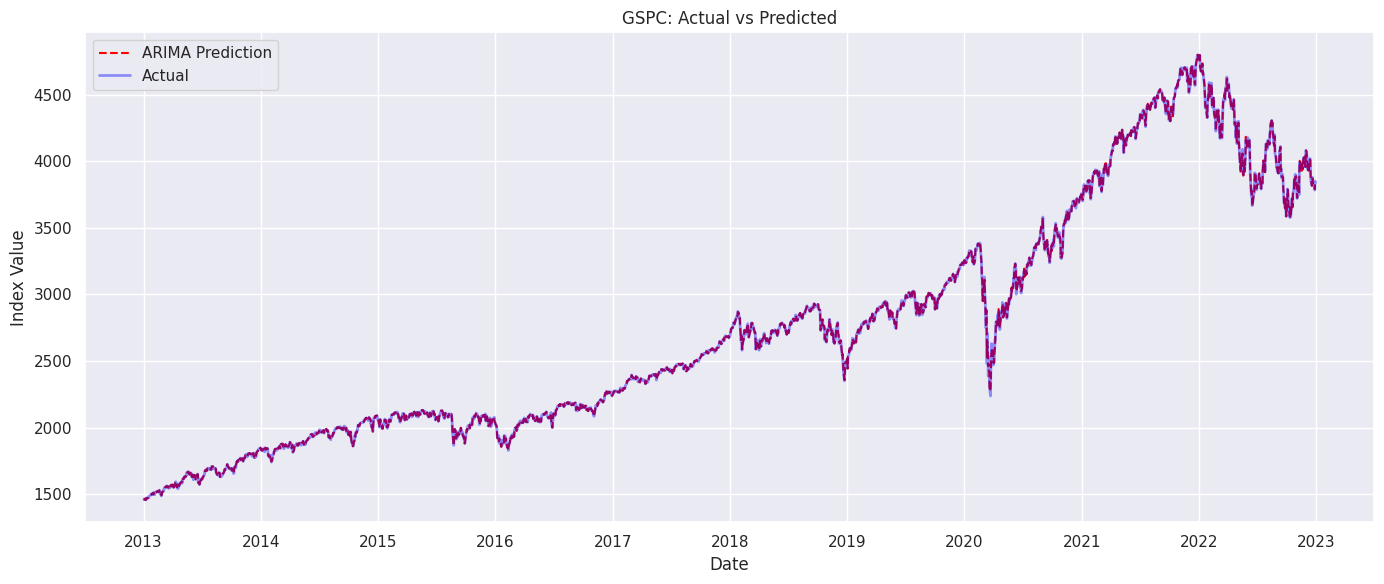

In [115]:
pred_series = pd.Series(predictions, index=df.index[0:])  # Skip the first index due to differencing (d=1)

# Plotting both predictions and actual values, hard to see since they are similar
plt.figure(figsize=(14, 6))
plt.plot(pred_series, label='ARIMA Prediction', linestyle='--', color='red')
plt.plot(df['GSPC'], label='Actual', linewidth=2, alpha=0.4, color='blue')
plt.title('GSPC: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Index Value')
plt.legend()
plt.tight_layout()
plt.show()



In [116]:
# Found package pmdarima which automatically runs through ARIMA to find best fit.  Used this to get values.  Chose 5 as max because based on the graphs above it looks like it should be 4 max.
stepwise_model = auto_arima(df['log_gspc'], start_p=1, start_q=1,
                            max_p=5, max_q=5, seasonal=False,
                            d=1, trace=True, error_action='ignore', suppress_warnings=True)
print(stepwise_model.summary())


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-15559.505, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-15503.774, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-15555.786, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-15548.320, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-15502.778, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-15563.272, Time=0.33 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-15565.455, Time=0.24 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-15563.650, Time=0.70 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-15561.457, Time=0.30 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-15563.948, Time=0.07 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0] intercept
Total fit time: 2.330 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2518
Model:               SARIMAX(2, 1, 0)   Lo

In [117]:
#Create ARIMA model
log_model = ARIMA(df['log_gspc'].dropna(), order=(2,1,0))
log_model_fit = log_model.fit()

# Print model AIC, BIC
log_aic = round(log_model_fit.aic, 1)
log_bic = round(log_model_fit.bic, 1)

log_aic, log_bic

(-15563.9, -15546.5)

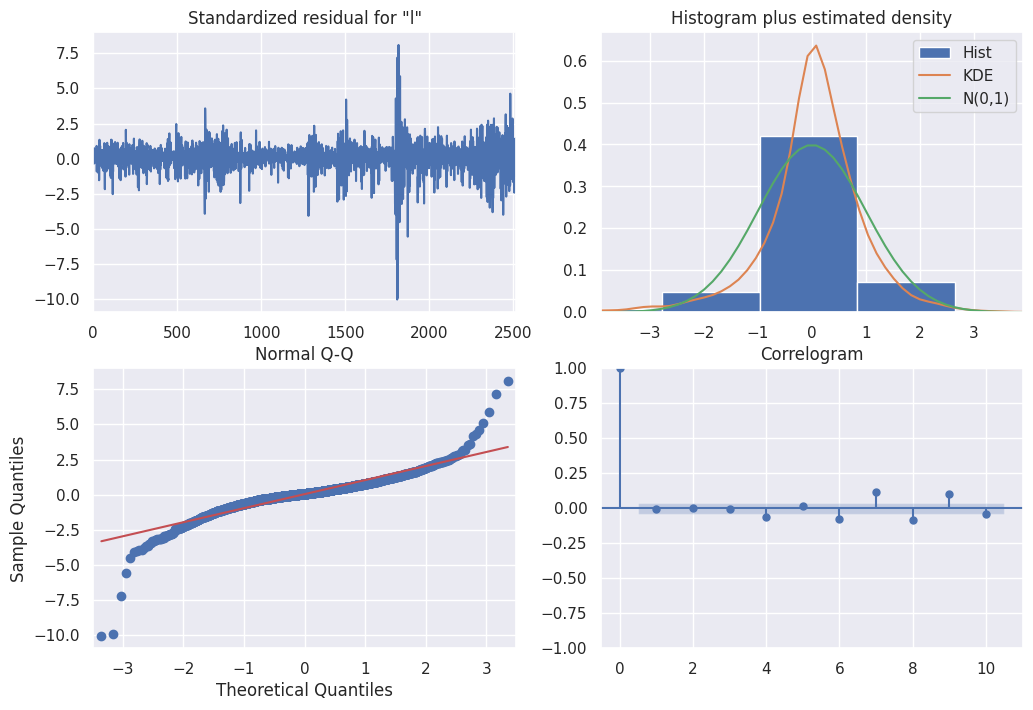

In [118]:
# Model Diagnostics
log_model_fit.plot_diagnostics(figsize=(12,8))
plt.show()

In [119]:
# Forecast next year
forecast = log_model_fit.forecast(steps=252) #252 trading days in a year

forecast_exp = np.exp(forecast)

# Create future index
future_dates = pd.date_range(start=df.index[-1] + pd.DateOffset(days=1), periods=252)

forecast_exp

2518    3845.437844
2519    3843.959806
2520    3844.571358
2521    3844.386453
2522    3844.453811
           ...     
2765    3844.437638
2766    3844.437638
2767    3844.437638
2768    3844.437638
2769    3844.437638
Name: predicted_mean, Length: 252, dtype: float64

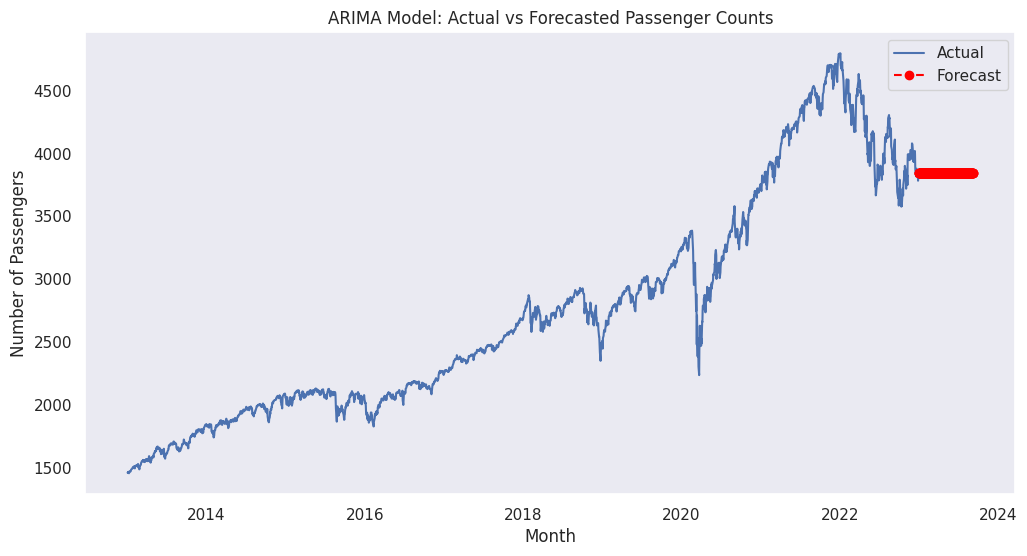

In [120]:
plt.figure(figsize=(12, 6))

# Plot actual data
plt.plot(df.index, df['GSPC'], label="Actual", linestyle='-')

# Plot forecasted values
plt.plot(future_dates, forecast_exp, label="Forecast", marker='o', linestyle='--', color='red')
plt.title("ARIMA Model: Actual vs Forecasted Passenger Counts")
plt.xlabel("Month")
plt.ylabel("Number of Passengers")
plt.legend()
plt.grid()
plt.show()

In [121]:
# Get predictions
log_predictions = np.exp(log_model_fit.predict(start=1, end=len(df)))  # Get predictions for the original time series range

# True values
true_values = df['GSPC']

# predictions = predictions[true_values.index]  # Align predictions with true_values index
log_predictions = log_predictions.to_numpy()




# Calculate error metrics
log_mae = round(mean_absolute_error(true_values, log_predictions), 4)
log_rmse = round(np.sqrt(mean_squared_error(true_values, log_predictions)), 4)
log_mape = round(mean_absolute_percentage_error(true_values, log_predictions), 4)

print(f"Mean Absolute Error: {log_mae}")
print(f"Root Mean Square Error : {log_rmse}")
print(f"Mean Absolute Percent Error: {log_mape}")


Mean Absolute Error: 3.2068
Root Mean Square Error : 5.2663
Mean Absolute Percent Error: 0.0011


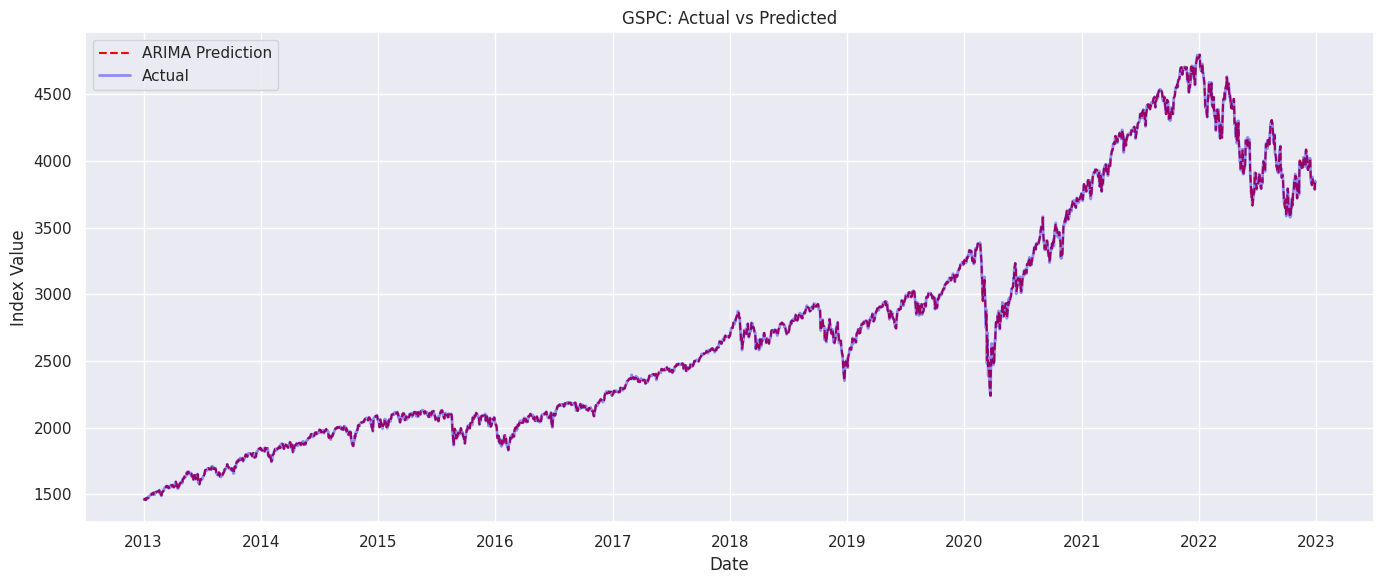

In [122]:
pred_series = pd.Series(log_predictions, index=df.index[0:])  # Skip the first index due to differencing (d=1)

# Plotting both predictions and actual values, hard to see since they are similar
plt.figure(figsize=(14, 6))
plt.plot(pred_series, label='ARIMA Prediction', linestyle='--', color='red')
plt.plot(df['GSPC'], label='Actual', linewidth=2, alpha=0.4, color='blue')
plt.title('GSPC: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Index Value')
plt.legend()
plt.tight_layout()
plt.show()
